In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import keras

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.pkl.gz')
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
x_train = x_train[:10000]

In [4]:
#my tips:Gauss sampling,sample Z
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [10]:
batch_size = 100
original_dim = 784   #28*28
latent_dim = 2
intermediate_dim = 200
nb_epoch = 30
epsilon_std = 1.0

In [11]:
#my tips:encoding
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [12]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [13]:
#This model will include all layers required in the computation of x given x_decoded_mean.
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.99, beta_2=0.999, amsgrad=False)
vae = Model(x, x_decoded_mean)
vae.compile(optimizer=adam, loss=vae_loss)

In [14]:
# train the VAE on MNIST digits
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 10000 samples, validate on 10000 samples
Epoch 1/30
 - 2s - loss: 212.0059 - val_loss: 188.1854
Epoch 2/30
 - 1s - loss: 183.4003 - val_loss: 179.2054
Epoch 3/30
 - 1s - loss: 176.4318 - val_loss: 174.5061
Epoch 4/30
 - 1s - loss: 172.3940 - val_loss: 171.0942
Epoch 5/30
 - 1s - loss: 169.8203 - val_loss: 168.9483
Epoch 6/30
 - 2s - loss: 167.9203 - val_loss: 167.7573
Epoch 7/30
 - 1s - loss: 166.8626 - val_loss: 167.7058
Epoch 8/30
 - 1s - loss: 165.6841 - val_loss: 166.2063
Epoch 9/30
 - 1s - loss: 164.7009 - val_loss: 165.6324
Epoch 10/30
 - 2s - loss: 164.0166 - val_loss: 165.2160
Epoch 11/30
 - 2s - loss: 163.3308 - val_loss: 165.0771
Epoch 12/30
 - 2s - loss: 162.6604 - val_loss: 164.3010
Epoch 13/30
 - 2s - loss: 162.3625 - val_loss: 163.8043
Epoch 14/30
 - 2s - loss: 162.2700 - val_loss: 164.4287
Epoch 15/30
 - 2s - loss: 161.6241 - val_loss: 162.6907
Epoch 16/30
 - 2s - loss: 160.9310 - val_loss: 162.7858
Epoch 17/30
 - 2s - loss: 160.1647 - val_loss: 162.5412
Epoch 1

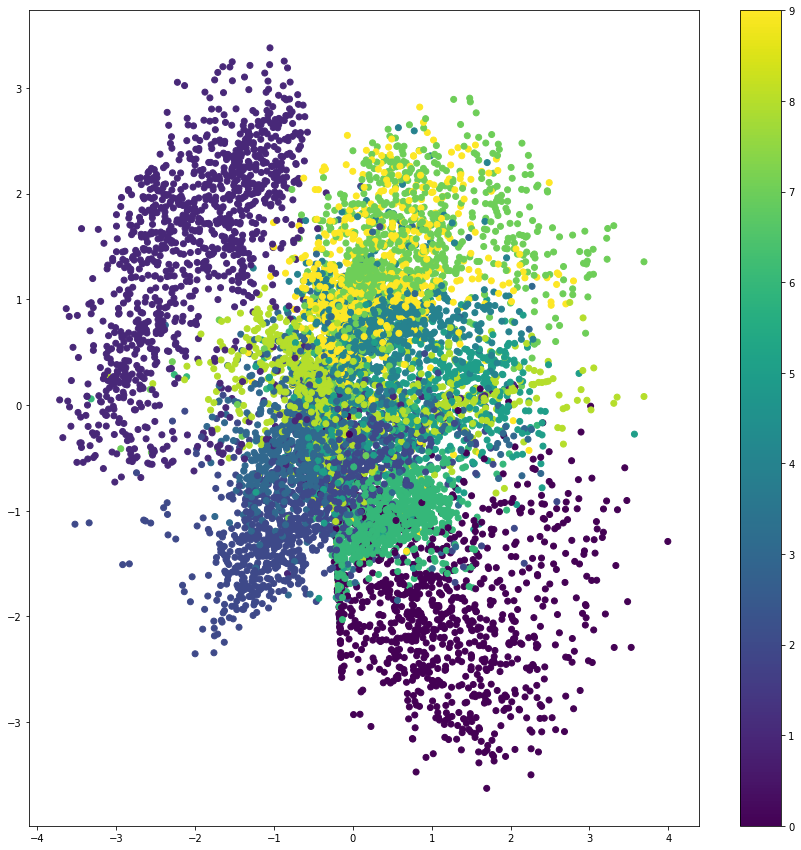

In [15]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
 
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(15,15))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
 
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

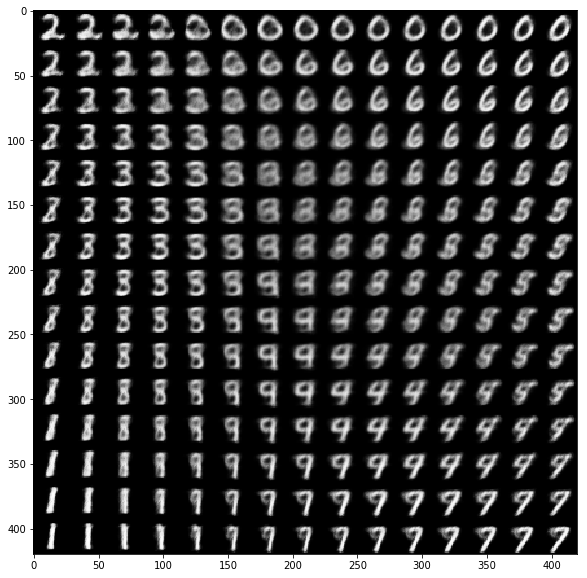

In [16]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
 
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [17]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        print(yi)

-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.6971414348463